In [29]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# Load the dataset
training_df = pd.read_csv('twitter_training.csv', encoding='ISO-8859-1', header=None)
validation_df = pd.read_csv('twitter_validation.csv', encoding='ISO-8859-1', header=None)

# Suggested headers
headers = ['ID', 'candidate', 'sentiment', 'text']

# Rename the columns for both training and validation datasets
training_df.columns = headers
validation_df.columns = headers

# Shuffle the data
training_df = shuffle(training_df)
validation_df = shuffle(validation_df)

# Display the first few rows to verify
print(training_df.head())
print(validation_df.head())

# Preprocess the text data by removing stop words, punctuation, converting to lowercase, and other cleaning steps
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Remove stop words
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

training_df['text'] = training_df['text'].apply(preprocess_text)
validation_df['text'] = validation_df['text'].apply(preprocess_text)

# Display the first few rows after preprocessing
print(training_df.head())
print(validation_df.head())


          ID                  candidate sentiment  \
22777   4303                      CS-GO  Positive   
3177    1752  CallOfDutyBlackopsColdWar   Neutral   
16086   3154                      Dota2  Negative   
45789  11859                    Verizon  Positive   
32722   6415                   Fortnite  Positive   

                                                    text  
22777                                       Feels good:)  
3177   Excited for . Choose your gameplay with high s...  
16086  FUCK MY TEAM OI WHY U GUYS DO THIS TO ME @valv...  
45789                                               Yooo  
32722                                           and Awww  
        ID               candidate sentiment  \
549  12991           Xbox(Xseries)  Negative   
990  11504    TomClancysRainbowSix  Positive   
367  10444  RedDeadRedemption(RDR)   Neutral   
723  11155    TomClancysGhostRecon   Neutral   
111   5265             Hearthstone   Neutral   

                                      

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - 'C:\\Users\\penfr/nltk_data'
    - 'C:\\Users\\penfr\\anaconda3\\nltk_data'
    - 'C:\\Users\\penfr\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\penfr\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\penfr\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [30]:
# Keep only the relevant columns
data = training_df[['candidate', 'sentiment', 'text']]

def preprocess_text(text):
    text = text.lower()  
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    stop_words = set(stopwords.words('english'))  # Remove stop words
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

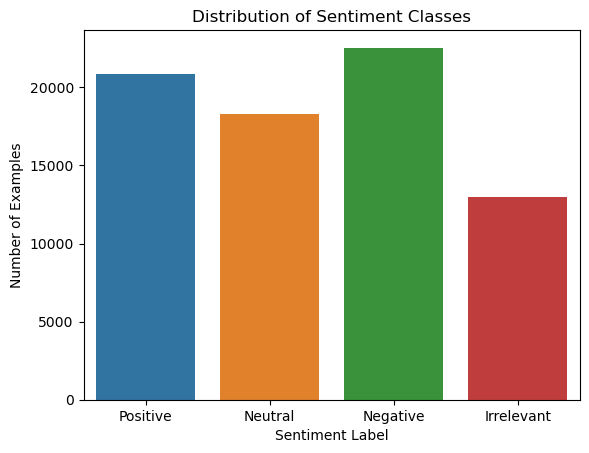

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="sentiment", data=data)  
plt.xlabel("Sentiment Label")
plt.ylabel("Number of Examples")
plt.title("Distribution of Sentiment Classes")
plt.show()

In [31]:
#Tokenize and pad sequences
max_words = 10000
max_len = 100

#Check data type
print(training_df['text'].dtypes)

#Remove rows with non-string data (assuming other columns are okay)
training_df = training_df[training_df['text'].notna()]
training_df = training_df[training_df['text'].apply(lambda x: isinstance(x, str))]

#Now proceed with tokenizing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_df['text'])

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(training_df['text'])

train_sequences = tokenizer.texts_to_sequences(training_df['text'])
train_padded = pad_sequences(train_sequences, maxlen=max_len)

validation_sequences = tokenizer.texts_to_sequences(validation_df['text'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_len)

#Convert sentiment labels to numerical format
sentiment_labels = {'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Irrelevant': 3}
training_df['sentiment'] = training_df['sentiment'].map(sentiment_labels)
validation_df['sentiment'] = validation_df['sentiment'].map(sentiment_labels)

train_labels = training_df['sentiment'].values
validation_labels = validation_df['sentiment'].values


object


In [27]:
#Build the model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization on kernel
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization on dense layer kernel
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
#from tensorflow.keras.callbacks import EarlyStopping
# Add early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 128)          1280000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 100, 128)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_4 (Conv1D)           (None, 98, 32)            12320     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 128)               4224      
                                                                 
 dense_10 (Dense)            (None, 4)                

In [33]:
#Train the model
history = model.fit(train_padded, train_labels, epochs=20, batch_size=128, validation_split=0.2, verbose=1)
#Evaluate the model
loss, accuracy = model.evaluate(validation_padded, validation_labels, verbose=1)
print(f'Test Accuracy: {accuracy}')


Epoch 1/20
463/463 [==============================] - 20s 44ms/step - loss: 0.1875 - accuracy: 0.9537 - val_loss: 0.4354 - val_accuracy: 0.8741
Epoch 2/20
463/463 [==============================] - 18s 38ms/step - loss: 0.1750 - accuracy: 0.9563 - val_loss: 0.4291 - val_accuracy: 0.8778
Epoch 3/20
463/463 [==============================] - 24s 52ms/step - loss: 0.1664 - accuracy: 0.9588 - val_loss: 0.4430 - val_accuracy: 0.8732
Epoch 4/20
463/463 [==============================] - 18s 40ms/step - loss: 0.1593 - accuracy: 0.9605 - val_loss: 0.4381 - val_accuracy: 0.8767
Epoch 5/20
463/463 [==============================] - 18s 39ms/step - loss: 0.1530 - accuracy: 0.9621 - val_loss: 0.4280 - val_accuracy: 0.8810
Epoch 6/20
463/463 [==============================] - 21s 44ms/step - loss: 0.1484 - accuracy: 0.9624 - val_loss: 0.4264 - val_accuracy: 0.8786
Epoch 7/20
463/463 [==============================] - 26s 55ms/step - loss: 0.1422 - accuracy: 0.9642 - val_loss: 0.4239 - val_accuracy: